### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import logging
import optuna
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("lightgbm").setLevel(logging.WARNING)

from statsmodels.tsa.seasonal import seasonal_decompose

# Importando libs de plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

### EDA

In [2]:
data = pd.read_csv('taxi.csv')

In [3]:
data['datetime'] = pd.to_datetime(data['datetime'], infer_datetime_format=True)
data.set_index('datetime', inplace=True)

In [4]:
print(data.shape)
print(data.index.nunique())

(26496, 1)
26496


In [5]:
data = data.resample('1H').sum();

In [6]:
data.index.is_monotonic_increasing

True

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


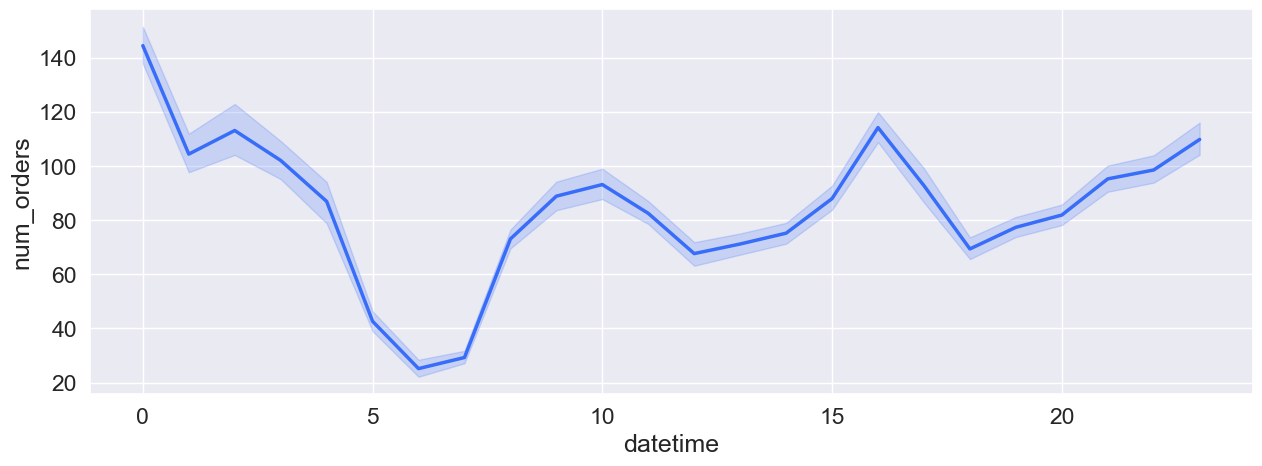

In [10]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.lineplot(x = data.index.hour, y = data['num_orders']);

In [11]:
rolling_mean = data['num_orders'].rolling(2).mean()

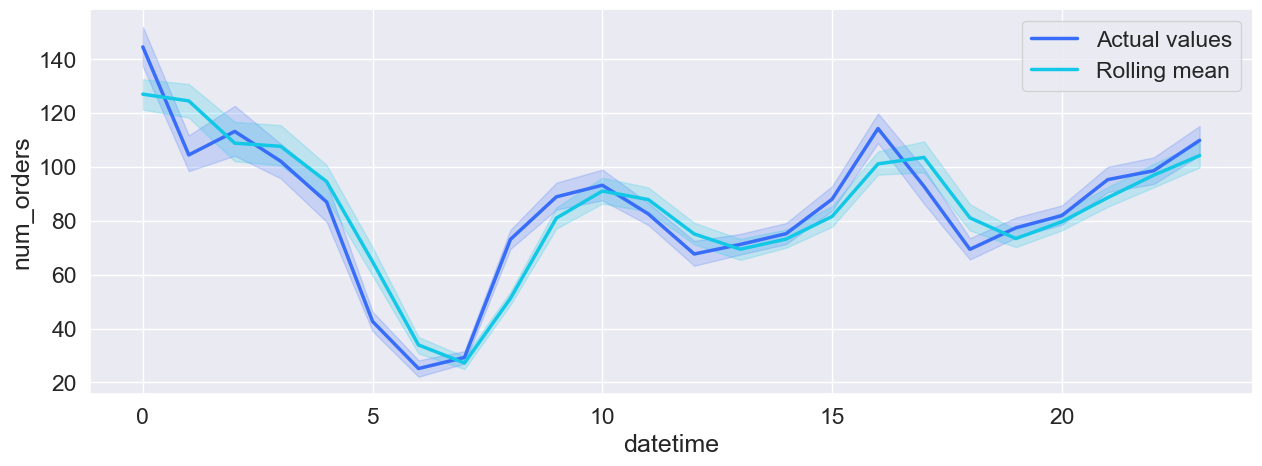

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.lineplot(x=data.index.hour, y=data['num_orders'], label='Actual values')
sns.lineplot(x=data.index.hour, y=rolling_mean, label='Rolling mean');

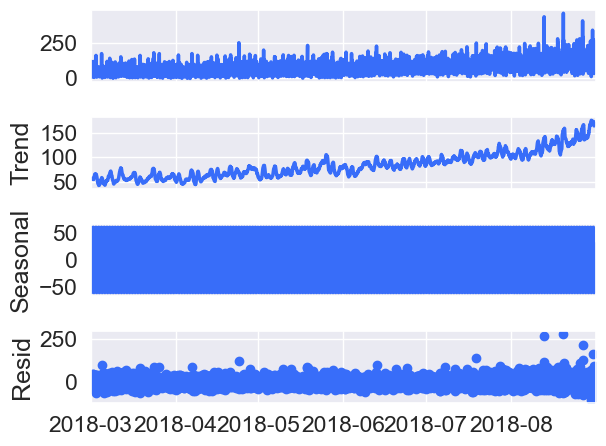

In [13]:
decomposed = seasonal_decompose(data)
decomposed.plot();

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

In [15]:
make_features(data, 6, 2)
data.dropna(inplace=True)

In [16]:
data.head(5)

,num_orders,hour,month,day,dayofweek,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 06:00:00,12,6,3,1,3,1,6.0,43.0,66.0,71.0,85.0,124.0,24.5
2018-03-01 07:00:00,15,7,3,1,3,1,12.0,6.0,43.0,66.0,71.0,85.0,9.0
2018-03-01 08:00:00,34,8,3,1,3,1,15.0,12.0,6.0,43.0,66.0,71.0,13.5
2018-03-01 09:00:00,69,9,3,1,3,1,34.0,15.0,12.0,6.0,43.0,66.0,24.5
2018-03-01 10:00:00,64,10,3,1,3,1,69.0,34.0,15.0,12.0,6.0,43.0,51.5


### Split

In [17]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

n = len(data)
train_end = int(n * train_size)
val_end = train_end + int(n * val_size)

In [18]:
features = ['hour', 'month', 'day', 'dayofweek', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean']

X_train = data.iloc[:train_end][features]
y_train = data.iloc[:train_end]['num_orders']

X_val = data.iloc[train_end:val_end][features]
y_val = data.iloc[train_end:val_end]['num_orders']

X_test = data.iloc[val_end:][features]
y_test = data.iloc[val_end:]['num_orders']

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [19]:
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_train_val))

3528
441
441
3969


### Training

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)

In [21]:
lr_rmse = mean_squared_error(y_val, lr_pred, squared=False)
lr_rmse

40.69026549426284

In [22]:
def objective_xg(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20)
    }

    xg = XGBRegressor(**params)
    xg.fit(X_train, y_train)
    xg_pred = xg.predict(X_val)
    xg_rmse = mean_squared_error(y_val, xg_pred, squared=False)

    return xg_rmse

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_xg, n_trials=50)

In [24]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 667, 'max_depth': 6, 'learning_rate': 0.010058027553435902, 'subsample': 0.9120265067271961, 'colsample_bytree': 0.9567917168408759, 'min_child_weight': 2}
Best RMSE: 32.93049072457486


In [25]:
def objective_lg(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)
    }

    lg = LGBMRegressor(**params, verbose=-1)
    lg.fit(X_train, y_train)
    lg_pred = lg.predict(X_val)
    lg_rmse = mean_squared_error(y_val, lg_pred, squared=False)
    return lg_rmse

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_lg, n_trials=50)

In [27]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 938, 'max_depth': 6, 'learning_rate': 0.008481721906994784, 'num_leaves': 122, 'subsample': 0.41187840456317515, 'colsample_bytree': 0.8978427324683967, 'min_data_in_leaf': 11}
Best RMSE: 32.71952868661242


### Testing

LinearRegression

In [28]:
lr = LinearRegression()
lr.fit(X_train_val, y_train_val)
lr_pred = lr.predict(X_test)

In [29]:
lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
lr_rmse

53.136762904505886

XGBoost

In [36]:
xg = XGBRegressor(n_estimators=667, max_depth=6, learning_rate=0.010058027553435902, subsample=0.9120265067271961, colsample_bytree=0.9567917168408759, min_child_weight=2)
xg.fit(X_train_val, y_train_val)
xg_pred = xg.predict(X_test)

In [37]:
xg_rmse = mean_squared_error(y_test, xg_pred, squared=False)
xg_rmse

45.30653763993929

LightGBM

In [34]:
lg = LGBMRegressor(n_estimators=938, max_depth=6, learning_rate=0.008481721906994784, num_leaves=122, subsample=0.41187840456317515, colsample_bytree=0.8978427324683967, min_data_in_leaf=11, verbose=-1)
lg.fit(X_train_val, y_train_val)
lg_pred = lg.predict(X_test)

In [35]:
lg_rmse = mean_squared_error(y_test, lg_pred, squared=False)
lg_rmse

41.09328613114721